# Loading the libraries

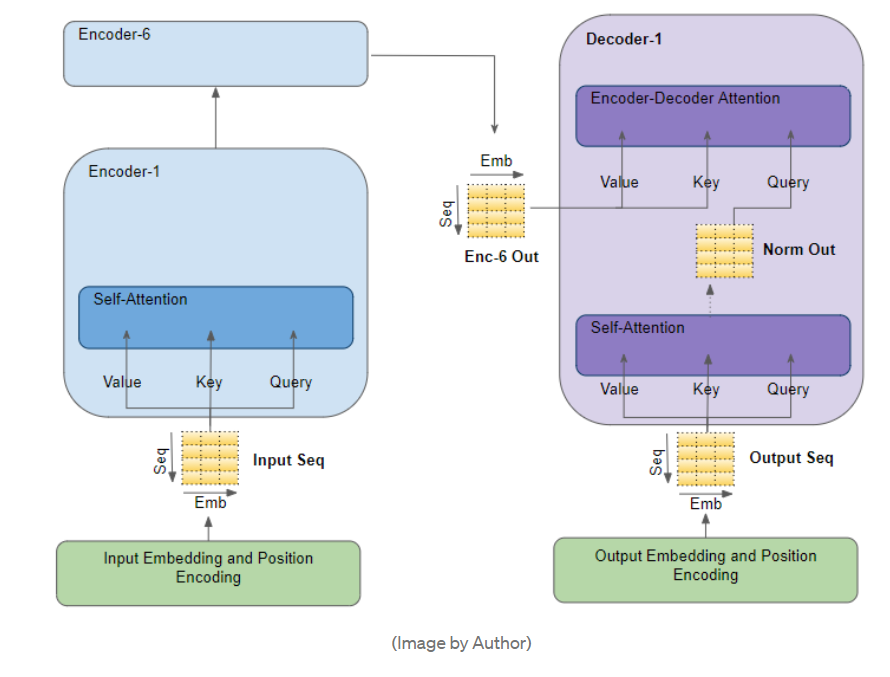

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import os
import io
import gc
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from google.colab import drive

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Setting some parameters and hyperparameters for our model

In [ ]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
NUM_SAMPLES = 12801 
MAX_VOCAB_SIZE = 2**14 

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 5  # Number of epochs to train for.
MAX_LENGTH = 120

# Global parameters
root_folder='/content/drive/MyDrive'
checkpoint_folder = "/medlane/relattn"
checkpoint_path = os.path.abspath(os.path.join(root_folder, checkpoint_folder))


Setting the hyperparameters and parameters of the model and training process:


In [ ]:
# Set hyperparamters for the model
D_MODEL = 256 #256 
N_LAYERS = 6 # 6
FFN_UNITS = 512 # 512
N_HEADS = 4 # 4
DROPOUT_RATE = 0.1 # 0.1

## Loading the dataset

Mount our Google Drive unit to access the datafiles from the notebook

In [ ]:
file_path_train_raw = "/content/drive/MyDrive/medlane/data/train_medlane/raw.txt"
file_path_train_simple = "/content/drive/MyDrive/medlane/data/train_medlane/simple.txt"

In [ ]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [(w) for w in lines[:num_examples]]
    return (word_pairs)

target_data = create_dataset(file_path_train_simple,12801)
input_data = create_dataset(file_path_train_raw,12801)

In [ ]:
print('Number of sentences: ',len(input_data))
print(input_data[:5])
print(target_data[:5])

Number of sentences:  12801
['Stage 2 ulcers : On sacrum and scrotum .', '"Labs were significant for d-dimer 6218 , troponin 0.05 , creatinine 1.4 , Hco3 20 and wbc 11.3 ."', 'They drove down from Country 6607 to Hospital1 18 Emergency Department for evaluation .', '"Serum tox screens were negative for benzodiazepenes , barbituates and tricyclic antidepressants ."', 'Known lastname was admitted to the Neurosurgery service after a study revealed a break in her VPS catheter at the level of her neck .']
['Stage 2 break in skin : On sacrum and scrotum .', '"Labs were significant for d-dimer 6218 , troponin 0.05 , creatinine 1.4 , Bicarbonate 20 and white blood cells 11.3 ."', 'They drove down from Country 6607 to Hospital1 18 Emergency Department for evaluation .', '"Serum toxicology test were negative for benzodiazepenes , barbituates and tricyclic antidepressants ."', 'Patient was admitted to the Neurosurgery service after a study revealed a break in her shunt catheter at the level of he

In [ ]:
def subword_tokenize(corpus, vocab_size, max_length):
  # Create the vocabulary using Subword tokenization
  tokenizer_corpus = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    corpus, target_vocab_size=vocab_size)
  # Get the final vocab size, adding the eos and sos tokens
  num_words = tokenizer_corpus.vocab_size + 2
  # Set eos and sos token
  sos_token = [num_words-2]
  eos_token = [num_words-1]
  # Tokenize the corpus
  sentences = [sos_token + tokenizer_corpus.encode(sentence) + eos_token
          for sentence in corpus]
  # Identify the index of the sentences longer than max length
  idx_to_remove = [count for count, sent in enumerate(sentences)
                 if len(sent) > max_length]
  #Pad the sentences
  sentences = tf.keras.preprocessing.sequence.pad_sequences(sentences,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=max_length)
  
  return sentences, tokenizer_corpus, num_words, sos_token, eos_token, idx_to_remove


In [ ]:
# Tokenize and pad the input sequences
encoder_inputs, tokenizer_inputs, num_words_inputs, sos_token_input, eos_token_input, del_idx_inputs= subword_tokenize(input_data, 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH)
# Tokenize and pad the outputs sequences
decoder_outputs, tokenizer_outputs, num_words_output, sos_token_output, eos_token_output, del_idx_outputs = subword_tokenize(target_data, 
                                                                                                        MAX_VOCAB_SIZE, MAX_LENGTH)

In [ ]:
# Check the tokenize function
print(encoder_inputs.shape, sos_token_input, eos_token_input)
#print(decoder_inputs[0], sos_token_output, eos_token_output)
print(decoder_outputs[0], sos_token_output, eos_token_output)

(12801, 120) [17951] [17952]
[17306  2967    90  1969    14  1499    34    52 10105     2  6868     7
 17307     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0] [17306] [17307]


In [ ]:
print('Size of Input Vocabulary: ', num_words_inputs)
print('Size of Output Vocabulary: ', num_words_output)

Size of Input Vocabulary:  17953
Size of Output Vocabulary:  17308


# Create the batch data generator

In [ ]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_outputs))
dataset = dataset.shuffle(len(input_data), reshuffle_each_iteration=True).batch(
    BATCH_SIZE, drop_remainder=True)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Building a Transformer

In [ ]:
def scaled_dot_product_attention(queries, keys, values, mask):
    # Calculate the dot product, QK_transpose
   
    product = tf.matmul(queries, keys, transpose_b=True)
    # Get the scale factor
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)
    # Apply the scale factor to the dot product
    scaled_product = product / tf.math.sqrt(keys_dim)
    # Apply masking when it is requiered
    if mask is not None:
        scaled_product += (mask * -1e9)
    # dot product with Values
    attention = tf.matmul(tf.nn.softmax(scaled_product, axis=-1), values)
    #print(attention.shape)
    
    return attention

In [ ]:
class MultiHeadAttention1(layers.Layer):
    
  
    def __init__(self, d_model, num_heads,length):
        super(MultiHeadAttention1, self).__init__()
        self.n_heads = num_heads
        self.d_model = d_model  # typically 512
        self.length=length
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.n_heads == 0
        # Calculate the dimension of every head or projection
        self.d_head = self.d_model // self.n_heads
        # Set the weight matrices for Q, K and V
        self.query_lin = layers.Dense(units=self.d_model)
        self.key_lin = layers.Dense(units=self.d_model)
        self.value_lin = layers.Dense(units=self.d_model)
        # Set the weight matrix for the output of the multi-head attention W0
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)
        # Set the dimension of the projections
        shape = (batch_size,
                 -1,
                 self.n_heads,
                 self.d_head)
        # Split the input vectors
        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)
        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask):
        # Get the batch size
        batch_size = tf.shape(queries)[0]
        # Set the Query, Key and Value matrices
        queries = self.query_lin(queries)
        keys = self.key_lin(keys)
        values = self.value_lin(values)
        # Split Q, K y V between the heads or projections
        queries = self.split_proj(queries, batch_size)
        keys = self.split_proj(keys, batch_size)
        values = self.split_proj(values, batch_size)
        # Apply the scaled dot product
        #print(queries.shape, keys.shape, values.shape)
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        # Get the attention scores
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        # Concat the h heads or projections
        concat_attention = tf.reshape(attention,
                                      shape=(batch_size, -1, self.d_model))
        # Apply W0 to get the output of the multi-head attention
        outputs = self.final_lin(concat_attention)
        
        return outputs

In [ ]:
class MultiHeadAttention(layers.Layer):
    
      def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model  # typically 512
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model, activation='relu')
        self.wk = tf.keras.layers.Dense(d_model, activation='relu')
        self.wv = tf.keras.layers.Dense(d_model, activation='relu')
        
        self.dense = tf.keras.layers.Dense(d_model, activation='relu')
       
      def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
     
        return tf.transpose(x, perm=[0, 2, 1, 3])

      def _generate_relative_positions_matrix(self, length, max_relative_position,
                                            cache=False):
        """Generates matrix of relative positions between inputs."""
        if not cache:
          range_vec = tf.range(length)
          range_mat = tf.reshape(tf.tile(range_vec, [length]), [length, length])
          distance_mat = range_mat - tf.transpose(range_mat)
        else:
          distance_mat = tf.expand_dims(tf.range(-length+1, 1, 1), 0)
        distance_mat_clipped = tf.clip_by_value(distance_mat, -max_relative_position,
                                                max_relative_position)
        # Shift values to be >= 0. Each integer still uniquely identifies a relative
        # position difference.
     
        final_mat = distance_mat_clipped + max_relative_position
        
     
        return final_mat

      def _generate_relative_positions_embeddings(self, length, depth,
                                                  max_relative_position, name,
                                                  cache=False):
        """Generates tensor of size [1 if cache else length, length, depth]."""
        with tf.compat.v1.variable_scope(name):
          
          relative_positions_matrix = self._generate_relative_positions_matrix(
              length, max_relative_position, cache=cache)
          vocab_size = max_relative_position * 2 + 1
          # Generates embedding for each relative position of dimension depth.
          embeddings_table = tf.compat.v1.get_variable(name, [vocab_size, depth])
          embeddings = tf.gather(embeddings_table, relative_positions_matrix)
       
          return embeddings 

      def _relative_attention_inner(self, x, y, z, transpose,mask,length):
        batch_size = tf.shape(x)[0]
        heads = N_HEADS
        
                                                                   
        # xy_matmul is [batch_size, heads, length or 1, length or depth]
        xy_matmul = tf.matmul(x, y, transpose_b=transpose)
       
        # x_t is [length or 1, batch_size, heads, length or depth]
        x_t = tf.transpose(x, [2, 0, 1, 3])
        
        # x_t_r is [length or 1, batch_size * heads, length or depth]
        x_t_r = tf.reshape(x_t, [length, heads * batch_size, -1])
        
        # x_tz_matmul is [length or 1, batch_size * heads, length or depth]
        x_tz_matmul = tf.matmul(x_t_r, z, transpose_b=transpose) 
       
        # x_tz_matmul_r is [length or 1, batch_size, heads, length or depth]
        x_tz_matmul_r = tf.reshape(x_tz_matmul, [length, batch_size, heads, -1])
        
        # x_tz_matmul_r_t is [batch_size, heads, length or 1, length or depth]
        x_tz_matmul_r_t = tf.transpose(x_tz_matmul_r, [1, 2, 0, 3])
     
      
        
        return tf.math.add(xy_matmul, x_tz_matmul_r_t)

      def dot_product_attention_relative(self,length, q,
                                      k,
                                      v,
                                      mask,
                                      bias,
                                      max_relative_position,
                                      dropout_rate=0.0,
                                      image_shapes=None,
                                      save_weights_to=None,
                                      name=None,
                                      make_image_summary=True,
                                      cache=False):
        if not max_relative_position:
          raise ValueError("Max relative position (%s) should be > 0 when using "
                          "relative self attention." % (max_relative_position))
        with tf.compat.v1.variable_scope(
            name, default_name="dot_product_attention_relative",
            values=[q, k, v]) as scope:

          # This calculation only works for self attention.
          # q, k and v must therefore have the same shape.
          if not cache:
            q.get_shape().assert_is_compatible_with(k.get_shape())
            q.get_shape().assert_is_compatible_with(v.get_shape())
          
          # Use separate embeddings suitable for keys and values.
          depth = self.depth #64 #128   #self.depth 512/4
         
          # print('Error...')
          relations_keys = self._generate_relative_positions_embeddings(length, depth, max_relative_position, "relative_positions_keys",cache=cache)
          
          relations_values = self._generate_relative_positions_embeddings(length, depth, max_relative_position, "relative_positions_values",cache=cache)
          
          # Compute self attention considering the relative position embeddings.
        
          logits = self._relative_attention_inner(q, k, relations_keys, True,mask,length)
          #print("logits",logits.shape,mask.shape)
          logits += (mask * -1e9)
          weights = tf.nn.softmax(logits)
          return self._relative_attention_inner(weights, v, relations_values, False,None,length), weights
    
      def call(self,length, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
       
        oot, attweight = self.dot_product_attention_relative(length,q, k, v, mask,bias=None, max_relative_position=16, dropout_rate=0.1,image_shapes=None,save_weights_to=None,name=None,make_image_summary=False,cache=False)
        scaled_attention = tf.transpose(oot, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        output = tf.reshape(output, (batch_size, length, self.d_model))
        
        return output#, attweight


In [ ]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(EncoderLayer, self).__init__()
        # Hidden units of the feed forward component
        self.FFN_units = FFN_units
        # Set the number of projectios or heads
        self.n_heads = n_heads
        # Dropout rate
        self.dropout_rate = dropout_rate
    
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        # Build the multihead layer
        self.multi_head_attention = MultiHeadAttention(self.d_model,self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        # Layer Normalization
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        # Fully connected feed forward layer
        self.ffn1_relu = layers.Dense(units=self.FFN_units, activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        # Layer normalization
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training):
        # Forward pass of the multi-head attention
        attention = self.multi_head_attention(inputs.shape[1],inputs,
                                              inputs,
                                              inputs,
                                              mask)
        
        attention = self.dropout_1(attention, training=training)

        # Call to the residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call to the FC layer
        outputs = self.ffn1_relu(attention)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        # Call to residual connection and the layer normalization
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [ ]:
class Encoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="encoder"):
        super(Encoder, self).__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        # The embedding layer
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stack of n layers of multi-head attention and FC
        
        self.enc_layers = [EncoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
        

    def call(self, inputs, mask, training):
        #print("encodermask",mask.shape)
        # Get the embedding vectors
        outputs = self.embedding(inputs)
        # Scale the embeddings by sqrt of d_model
        
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)
        
        return outputs

In [ ]:
class DecoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, n_heads, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.FFN_units = FFN_units
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        
        # Self multi head attention, causal attention
        self.multi_head_causal_attention = MultiHeadAttention( self.d_model,self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
     
        # Multi head attention, encoder-decoder attention 
        self.multi_head_enc_dec_attention = MultiHeadAttention1( self.d_model,self.n_heads,input_shape[1])
        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
      
        # Feed foward
        self.ffn1_relu = layers.Dense(units=self.FFN_units,
                                    activation="relu")
        self.ffn2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout_rate)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, enc_outputs, mask_1, mask_2,dec_inp_shape, training):
        # Call the masked causal attention
       
        attention = self.multi_head_causal_attention(inputs.shape[1],inputs,
                                                inputs,
                                                inputs,
                                                mask_1)
      
        attention = self.dropout_1(attention, training)
        # Residual connection and layer normalization
        attention = self.norm_1(attention + inputs)
        # Call the encoder-decoder attention
        
        attention_2 = self.multi_head_enc_dec_attention(attention,
                                                  enc_outputs,
                                                  enc_outputs,
                                                  mask_2)
       
        attention_2 = self.dropout_2(attention_2, training)
        # Residual connection and layer normalization
       
        attention_2 = self.norm_2(attention_2 + attention)
        # Call the Feed forward
       
        outputs = self.ffn1_relu(attention_2)
        outputs = self.ffn2(outputs)
        outputs = self.dropout_3(outputs, training)
        # Residual connection and layer normalization
        outputs = self.norm_3(outputs + attention_2)
        
        return outputs

In [ ]:
class Decoder(layers.Layer):
    
    def __init__(self,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 vocab_size,
                 d_model,
                 name="decoder"):
        super(Decoder, self).__init__(name=name)
        self.d_model = d_model
        self.n_layers = n_layers
        # Embedding layer
        self.embedding = self.embedding = layers.Embedding(vocab_size, d_model)
        self.dropout = layers.Dropout(rate=dropout_rate)
        # Stacked layers of multi-head attention and feed forward
        self.dec_layers = [DecoderLayer(FFN_units,
                                        n_heads,
                                        dropout_rate) 
                           for _ in range(n_layers)]
    
    def call(self, inputs, enc_outputs, mask_1, mask_2, dec_inp_shape,training):
        #print("decodermask",mask_1.shape,mask_2.shape)
        # Get the embedding vectors
    
        outputs = self.embedding(inputs)
        # Scale by sqrt of d_model
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.dropout(outputs, training)
        # Call the stacked layers
        
        for i in range(self.n_layers):
            outputs = self.dec_layers[i](outputs,
                                         enc_outputs,
                                         mask_1,
                                         mask_2,
                                         training)
        
        return outputs

# Transformer


In [ ]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 vocab_size_enc,
                 vocab_size_dec,
                 d_model,
                 n_layers,
                 FFN_units,
                 n_heads,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        # Build the encoder
        self.encoder = Encoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_enc,
                               d_model)
        # Build the decoder
        self.decoder = Decoder(n_layers,
                               FFN_units,
                               n_heads,
                               dropout_rate,
                               vocab_size_dec,
                               d_model)
        # build the linear transformation and softmax function
        self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq): #seq: (batch_size, seq_length)
        # Create the mask for padding
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
     
        return mask[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, seq):
        # Create the mask for the causal attention
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, dec_inputs, training):
        # Create the padding mask for the encoder
        enc_mask = self.create_padding_mask(enc_inputs)
        
        # Create the mask for the causal attention
        dec_mask_1 = tf.maximum(
            self.create_padding_mask(dec_inputs),
            self.create_look_ahead_mask(dec_inputs))
       
        # Create the mask for the encoder-decoder attention
        dec_mask_2 = self.create_padding_mask(enc_inputs)
       # print(enc_mask.shape,dec_mask_1.shape,dec_mask_2.shape)
        # Call the encoder
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        # Call the decoder
        
        dec_outputs = self.decoder(dec_inputs,
                                   enc_outputs,
                                   dec_mask_1,
                                   dec_mask_2,
                                   training)
        # Call the Linear and Softmax functions
      
        outputs = self.last_linear(dec_outputs)
       
        return outputs

In [ ]:
def loss_function(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    # Mask padding values, they do not have to compute for loss
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total
    
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [ ]:
def main_train(dataset, transformer, n_epochs, print_every=1):
  ''' Train the transformer model for n_epochs using the data generator dataset'''
  losses = []
  accuracies = []
  # In every epoch
  for epoch in range(n_epochs):
    print("Starting epoch {}".format(epoch+1))
    start = time.time()
    
    # Get a batch of inputs and targets
    for (batch, (enc_inputs, targets)) in enumerate(dataset):
        # Set the decoder inputs
        dec_inputs = targets[:, :-1]
        # Set the target outputs, right shifted
        dec_outputs_real = targets[:, 1:]
        with tf.GradientTape() as tape:
            # Call the transformer and get the predicted output
            predictions = transformer(enc_inputs, dec_inputs, True)
            # Calculate the loss
            loss = loss_function(dec_outputs_real, predictions)
            acc=accuracy_fn(dec_outputs_real, predictions)
        # Update the weights and optimizer
        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
        # Save and store the metrics
        #train_loss(loss)
        
        
        if batch % print_every == 0:
            losses.append(loss)
            accuracies.append(acc)
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, loss, acc))
            
    # Checkpoint the model on every epoch        
    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} in {}".format(epoch+1,
                                                        ckpt_save_path))
    print("Time for 1 epoch: {} secs\n".format(time.time() - start))

  return losses, accuracies

Now we define and create all the elements to train the model and evaluate it.

In [ ]:
# Clean the session
tf.keras.backend.clear_session()
# Create the Transformer model
transformer = Transformer(vocab_size_enc=num_words_inputs,
                          vocab_size_dec=num_words_output,
                          d_model=D_MODEL,
                          n_layers=N_LAYERS,
                          FFN_units=FFN_UNITS,
                          n_heads=N_HEADS,
                          dropout_rate=DROPOUT_RATE)

# Create the scheduler for learning rate decay
leaning_rate = CustomSchedule(D_MODEL)
# Create the Adam optimizer
optimizer = tf.keras.optimizers.Adam(leaning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)
        

It is very useful to checkpoint and save our model during training. Training can take a lot of time and we can restore the model for future training or use.

In [ ]:
#Create the Checkpoint 
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, "/ckpt", max_to_keep=2)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Last checkpoint restored.")

In [ ]:
# Train the model
losses, accuracies = main_train(dataset, transformer, EPOCHS, 2)

## Show some results from training

In [ ]:
'''fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()'''

# Make predictions

We have seen the scores obtained after training but what we are interested in making predictions and see how the model works with new sentences. The predict function will input a tokenize sentence to the model and return the predicted new sentence, in our example, a translation from english to spanish. 
- Tokenize the input sentence to a sequence of tokens
- Set the initial output sequence to the SOS token
- Until we reach the max length or the eos token is returned by the model
- Get the next word predicted. The model returns the logits, remember that the softmax function is applied in the loss calculation.
- Get the index in the vocabulary of the word with the highest probability
- Concat the next word predicted to the output sequence

In [ ]:
def predict(inp_sentence, tokenizer_in, tokenizer_out, target_max_len):
    # Tokenize the input sequence using the tokenizer_in
    inp_sentence = sos_token_input + tokenizer_in.encode(inp_sentence) + eos_token_input
    enc_input = tf.expand_dims(inp_sentence, axis=0)
    
    # Set the initial output sentence to sos
    out_sentence = sos_token_output
    # Reshape the output
    output = tf.expand_dims(out_sentence, axis=0)
    

    # For max target len tokens
    c=0
    for _ in range(target_max_len):
        # Call the transformer and get the logits 
       
        predictions = transformer(enc_input, output, False) #(1, seq_length, VOCAB_SIZE_ES)
        # Extract the logists of the next word
        prediction = predictions[:, -1:, :]
        # The highest probability is taken
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
       
        # Check if it is the eos token
        if predicted_id == eos_token_output or c==120:
            return tf.squeeze(output, axis=0)
        # Concat the predicted word to the output sequence
        c+=1
        output = tf.concat([output, predicted_id], axis=-1)
        
    return tf.squeeze(output, axis=0)

And finally our last function receives a sentence in english, calls the transformer to translate it to spanish and shows the result

In [ ]:
def translate(sentence):
    # Get the predicted sequence for the input sentence
    output = predict(sentence, tokenizer_inputs, tokenizer_outputs, MAX_LENGTH).numpy()
    # Transform the sequence of tokens to a sentence
    predicted_sentence = tokenizer_outputs.decode(
        [i for i in output if i < sos_token_output]
    )

    return predicted_sentence

First, we explore the predictions on sentences of our training dataset:

In [ ]:
#Show some translations
#sentences = ["Reports from Hospital6 20592 show the patient had an ETT-MIBI on 2103-12-24 which"]

for sentence in sentences:
  print("Input sentence: {}".format(sentence))
  predicted_sentence = translate(sentence)
  print("Output sentence:{} ".format(predicted_sentence))

Input sentence: Stage 2 ulcers : On sacrum and scrotum .
Output sentence:Stage 2 break in skin : On sacrum and scrotum . 
Input sentence: Labs were significant for d-dimer 6218 , troponin 0.05 , creatinine 1.4 , Hco3 20 and wbc 11.3 .
Output sentence:"# Labs were significant for d-dimer 6218 , Bicarbonate 20 and troponin 0.05 , Bicarbonate 0.05 , Bicarbonate 0.05 , Bicarbonate 20 and white blood cells 11.4.05 ." 
Input sentence: They drove down from Country 6607 to Hospital1 18 Emergency Department for evaluation .
Output sentence:They drove down from Country 6607 to Hospital1 18 Emergency Department Emergency Department Emergency Department for evaluation . 
Input sentence: Serum tox screens were negative for benzodiazepenes , barbituates and tricyclic antidepressants .
Output sentence:Serum toxicology test were negative for benzodiazepenes , barbituates and tricyclic antidepressants ." 
Input sentence: Known lastname was admitted to the Neurosurgery service after a study revealed a b

Nucleus sampling

In [ ]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import ModuleList
from torch.nn.modules.normalization import LayerNorm
import numpy as np
import os
from tqdm import tqdm_notebook, trange
import time

In [ ]:
import numpy as np
import math
import numpy.ma as ma
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
        
        Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
    """
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits



In [ ]:
temperature = 0.7
top_k = 15
top_p = 0.95
def generate(context, ntok):
    
        inp_sentence = sos_token_input + tokenizer_inputs.encode(context) 
        enc_input = tf.expand_dims(inp_sentence, axis=0)
        # Set the initial output sentence to sos
        out_sentence = sos_token_output
        # Reshape the output
        output = tf.expand_dims(out_sentence, axis=0)

      
        for c in range(ntok):
          predictions = (transformer(enc_input, output, False))
          predictions= predictions.numpy()
          logits = predictions[0, -1, :] / temperature
          filtered_logits = top_k_top_p_filtering(torch.tensor(logits), top_k=top_k, top_p=top_p)
          probabilities = F.softmax(filtered_logits, dim=-1)
          next_tok = torch.multinomial(probabilities, 1)
          next_tok = tf.cast(tf.expand_dims(next_tok, axis=0),tf.int32)
          if next_tok==17307:
            return output
          output = tf.concat([output, next_tok], axis=-1)
       
        return output

'''start = time.time()
out = generate( 'Reports from Hospital6 20592 show the patient had an ETT-MIBI on 2103-12-24 which', ntok = 30)
print(tokenizer_outputs.decode(out[0][1:]))
end = time.time()'''

"start = time.time()\nout = generate( 'Reports from Hospital6 20592 show the patient had an ETT-MIBI on 2103-12-24 which', ntok = 30)\nprint(tokenizer_outputs.decode(out[0][1:]))\nend = time.time()"

In [ ]:
for text in sentences:
  out=generate(text, ntok = 30)
  print(tokenizer_outputs.decode(out[0][1:]))

Stage 2 break in skin : On sacrum and scrotum .
"# Labs were significant for d-dimer 6218 , Bicarbonate 0.05 , Bicarbonate 20 and troponin 0.0.8 ."
They drove down from Country 6607 to Hospital1 18 Emergency Department Emergency Department Emergency Department Emergency Department for evaluation .
Serum toxicology test were negative for benzodiazepenes , barbituates and tricyclic antidepressants ."
Patient was admitted to the Neurosurgery service after a study revealed a study revealed a study at the level of her neck .
Her chest radiograph had what was likely a resolving lung infection .
He was instructed to take plavix for only three months .
"The mother is a 28-year-old , number of pregnancies 0-old , number of completed pregnancies 0-old , number of completed pregnancies 
Torso Imaging showed no overt malignancy but did demonstrate a right thyroid nodule .
2192-12-3 She was extubated 2192-3 and transferred to the general medical floor .
"# 53 year old Woman with diabetes , after Lo

Test

In [ ]:
file_path_test_raw = "/content/drive/MyDrive/medlane/data/test_medlane/raw_test.txt"
file_path_test_simple = "/content/drive/MyDrive/medlane/data/test_medlane/simple_test.txt"

targ_lang_test = create_dataset(file_path_test_simple,2301)
inp_lang_test = create_dataset(file_path_test_raw,2301)

In [ ]:
predicted_output=[]
c=1
with open('/content/drive/MyDrive/medlane/finaltest_relattiveAttnNucleus.txt',"a") as f:
  for i in range(870,len(inp_lang_test)):
    out=generate(inp_lang_test[i], ntok = 120)
    predicted_output.append(tokenizer_outputs.decode(out[0][1:]))
    f.write(tokenizer_outputs.decode(out[0][1:])+'\n')
    print(c,tokenizer_outputs.decode(out[0][1:]))
    c+=1
    f.flush()

1 Proportion ratio of platelets count remained stable , as well as low blood pressure remained stable .
2 When she arrived at anesthesia care unit for breathing distress .
3 A neurosurgery was consulted for traumatic head and neurosurgery treatment .
4 He reports decreased orally over the last 4 days percutaneous transluminal angioplasty .
5 He ruled in for an elevated in elevated in heart attack with an elevated in acute myocardial infarction .
6 "Based on the patient was made to understand 12 hours via their system , they made to continue him to intubate via advanced to put via advanced to re-operation ."
7 He was discharged on blood filtering 2 for evacuation of the operating room for evacuation of the operating room for evacuation and an exploratory laparotomy for evacuation of the solid swelling that is filled with blood .
8 She was started on ceftriaxone and flagyl for pyelonephritis .
9 He was transfused male with 2 units 18 's chest pain and 2 units of blood .
10 "There was no 

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
bleu_score_1gram=[]
bleu_score_2gram=[]
bleu_score_3gram=[]
bleu_score_4gram=[]
for i in range(len(predicted_output)):
  reference = [list(targ_lang_test[i])]
  candidate = list(predicted_output[i])
  score1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
  score2 = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
  score3 = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
  score4 = sentence_bleu(reference, candidate, weights=(0, 0, 0, 1))
  bleu_score_1gram.append(score1)
  bleu_score_2gram.append(score2)
  bleu_score_3gram.append(score3)
  bleu_score_4gram.append(score4)

In [ ]:
import statistics

BLEU1=statistics.mean(bleu_score_1gram)
BLEU2=statistics.mean(bleu_score_2gram)
BLEU3=statistics.mean(bleu_score_3gram)
BLEU4=statistics.mean(bleu_score_4gram)
print("BLEU1",BLEU1)
print("BLEU2",BLEU2)
print("BLEU3",BLEU3)
print("BLEU4",BLEU4)



BLEU1 0.606638376520146
BLEU2 0.4886924159608899
BLEU3 0.40714519016932976
BLEU4 0.36147479267774063


In [ ]:
!pip install rouge-score

In [ ]:
from rouge_score import rouge_scorer
import statistics
rogueL=[]
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
for i in range(len(predicted_output)):
  scores = scorer.score(targ_lang_test[i],predicted_output[i])
  rogueL.append(scores['rougeL'].fmeasure)

print("ROGUE-L",statistics.mean(rogueL))


ROGUE-L 0.45575143015036207


METEOR score

In [ ]:
!pip install -U nltk

     |████████████████████████████████| 1.5 MB 5.1 MB/s 
     |████████████████████████████████| 749 kB 46.1 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import nltk
from nltk.translate.meteor_score import meteor_score 
meteorScore=[]
for i in range(len(predicted_output)):
  meteorScore.append(meteor_score([targ_lang_test[i].split()],predicted_output[i].split()))
print("METEOR",statistics.mean(meteorScore))

METEOR 0.49502078213375433
